In [6]:
import scipy.integrate
import pints
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pints.toy

np.random.seed(123)

In [10]:
def load_wolf_moose_data(file_location):
    """Load the Wolves & Moose of Isle Royale data from csv file.
    
    Parameters
    ----------
    file_location : str
        path to the csv file containing the wolf-moose population numbers. The file should contain 
        the year in the first column, no. of moose in the second column, and the no. of wolves in the third column.

    Returns
    -------
    pandas.DataFrame
        Wolves & Moose of Isle Royale
    """
    names = ["year", "wolves", "moose", "calves", "senescent"]
    df = pd.read_csv(file_location, header=None, names=names)
    return df

dg = load_wolf_moose_data("wolf_moose_data1.csv").loc[:48]
dg['modified time'] = (dg['year'] - 1959)* 40 # taking into account the depletion rate of the wolf population in the absence of prey (normalised time)
mod_times = dg['modified time'].values  
dg['adults'] = dg['moose'].values - dg['calves'].values - dg['senescent'].values
dg['f1'] = dg['calves'].values / 160
dg['f2'] = dg['adults'].values / 320
dg['f3'] = dg['senescent'].values / 160
observed_data = dg[['f1', 'f2','f3', 'wolves']].values
init_calves, init_adults, init_senescent, init_wolves = dg['f1'].iloc[0], dg['f2'].iloc[0], dg['f3'].iloc[0], dg['wolves'].iloc[0]
print(init_calves)

0.125


In [11]:
class LotkaVolterraModel(pints.ForwardModel):

    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`. """
        return 4

    def n_parameters(self):
        return 1
    
    # def simulate(self, parameters, times):
    #     k_1, k_2, k_3, d_1, d_3, l_12, l_13, l_32, F = parameters

    #     def dy(t, state):
    #         f_1, f_2, f_3, f_4= state

    #         def safe_exp(x):
    #             return np.exp(np.clip(x, -709, 709)) # np.exp(x) overflows for x > 709 and underflows for x < -709
    #         #Ensure that the denominators are not zero or close to zero by adding a small epsilon value to avoid division by zero errors
    #         epsilon = 1e-10

    #         G = ((d_1 + d_3) * (1 - np.exp(-d_1*f_1 - d_3*f_3)))/((d_1*f_1 + d_3*f_3+epsilon) * (1-np.exp(-d_1-d_3)+epsilon))
            
    #         df_1 = k_1*((1-(f_1+f_2+f_3)/(F+epsilon))*(-f_1+l_12*f_2 + l_13*f_3)-(1-3/(F+epsilon))*(l_12+l_13-1)*f_1*f_4*G)
    #         df_2 = k_2*(f_1-f_2)
    #         df_3 = k_3*(l_32*f_2 -f_3 -(l_32-1)*f_3*f_4*G)
    #         df_4 = f_4*(-1+(1 - np.exp(-d_1*f_1 - d_3*f_3))/(1-np.exp(-d_1-d_3)+epsilon))
            
    #         return (df_1, df_2, df_3, df_4)

    #     initial_condition = np.asarray([np.log(init_calves), np.log(init_adults), np.log(init_senescent), np.log(init_wolves) ])

    #     res = scipy.integrate.solve_ivp(
    #         dy,
    #         (0, max(mod_times)),
    #         initial_condition,
    #         t_eval=mod_times )
        
    #     return res.y.T
    
    def simulate(self, parameters, times):
        k_1= parameters
        k_2, k_3 ,d_1, d_3, l_12, l_13, l_32, F = 0.00075, 0.006, 2.0, 2.4, 2.0, 1.0, 16.0, 8.0 

        def dy(t, state):
            f_1, f_2, f_3, f_4 = state

            def safe_exp(x):
                return np.exp(np.clip(x, -709, 709)) # np.exp(x) overflows for x > 709 and underflows for x < -709
            #Ensure that the denominators are not zero or close to zero by adding a small epsilon value to avoid division by zero errors
            epsilon = 1e-10

            G = ((d_1 + d_3) * (1 - np.exp(-d_1*f_1 - d_3*f_3)))/((d_1*f_1 + d_3*f_3+epsilon) * (1-np.exp(-d_1-d_3)+epsilon))
            
            df_1 = k_1*((1-(f_1+f_2+f_3)/(F+epsilon))*(-f_1+l_12*f_2 + l_13*f_3)-(1-3/(F+epsilon))*(l_12+l_13-1)*f_1*f_4*G)
            df_2 = k_2*(f_1-f_2)
            df_3 = k_3*(l_32*f_2 -f_3 -(l_32-1)*f_3*f_4*G)
            df_4 = f_4*(-1+(1 - np.exp(-d_1*f_1 - d_3*f_3))/(1-np.exp(-d_1-d_3)+epsilon))
            
            return (df_1, df_2, df_3, df_4)

        initial_condition = np.asarray([np.log(init_calves), np.log(init_adults), np.log(init_senescent), np.log(init_wolves) ])

        res = scipy.integrate.solve_ivp(
            dy,
            (0, max(mod_times)),
            initial_condition,
            t_eval=mod_times )
        
        return res.y.T
    
m = LotkaVolterraModel()


In [12]:
# Plot wolf and moose populations
fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, dg['wolves'], 'x', color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, (dg['f1'].values + dg['f2'].values +dg['f3'].values), 'x', color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

# Make a model object and run a simulation at arbitrary parameter values
arbitrary_params = 0.0125
# [ 0.0125, 0.00075, 0.006]

values = m.simulate(arbitrary_params, mod_times)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, np.exp(values[:,0]), color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, np.exp((values[:, 1] + values[:,2] + values[:,3])), color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_95621/3136141893.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_95621/3136141893.py:36: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


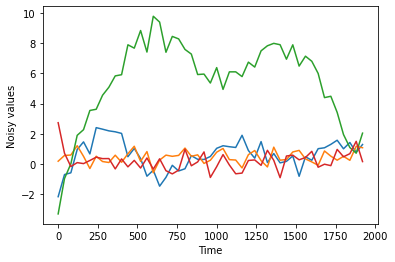

In [123]:
# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy values')
plt.plot(mod_times, noisy)
plt.show()

In [125]:
# Step 5: Set up the problem
problem = pints.MultiOutputProblem(m , mod_times, noisy)
error = pints.SumOfSquaresError(problem)

# Select boundaries. 
boundaries = pints.RectangularBoundaries(
    [0.001],
    [0.1])
    # [0.001, 0.0001, 0.001],
    # [0.1, 0.001, 0.01])

    # [0.001, 0.0001, 0.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    # [0.1, 0.001, 0.01, 10.0, 10., 10., 10., 100., 100.]

# transformation = pints.RectangularBoundariesTransformation(
#         [0.001, 0.0001, 0.001],
#     [0.1, 0.001, 0.01])

# opt = pints.OptimisationController(
#     error,
#     arbitrary_params,
#     method=pints.CMAES,
#     transformation=transformation
# )

# opt.set_log_interval(20)
# opt.set_max_evaluations(20000)

# found_parameters, found_value = opt.run()

found_parameters, found_value = pints.optimise(error, arbitrary_params, boundaries=boundaries)

print("Fit parameters:", found_parameters)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 4


/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_1861/1189900076.py:68: RuntimeWarning: overflow encountered in exp
  G = ((d_1 + d_3) * (1 - np.exp(-d_1*f_1 - d_3*f_3)))/((d_1*f_1 + d_3*f_3+epsilon) * (1-np.exp(-d_1-d_3)+epsilon))
/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_1861/1189900076.py:73: RuntimeWarning: overflow encountered in exp
  df_4 = f_4*(-1+(1 - np.exp(-d_1*f_1 - d_3*f_3))/(1-np.exp(-d_1-d_3)+epsilon))
/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_1861/1189900076.py:68: RuntimeWarning: invalid value encountered in double_scalars
  G = ((d_1 + d_3) * (1 - np.exp(-d_1*f_1 - d_3*f_3)))/((d_1*f_1 + d_3*f_3+epsilon) * (1-np.exp(-d_1-d_3)+epsilon))
/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_1861/1189900076.py:70: RuntimeWarning: invalid value encountered in double_scalars
  df_1 = k_1*((1-(f_1+f_2+f_3)/(F+epsilon))*(-f_1+l_12*f_2 + l_13*f_3)-(1-3/(F+epsilon))*(l_12+l_13-1)*f_1*f_4*G)
/var/folders/_k/n00gvc8n0mn06wzz2y3rqq

Iter. Eval. Best      Current   Time m:s
0     4      44.44389  44.44389   2:09.4

----------------------------------------
Unexpected termination.
Current score: 44.44388577203164
Current position:
 1.38538065569125922e-02
----------------------------------------


KeyboardInterrupt: 

In [ ]:
# Evaluate the model with the found parameters and plot the results
fig, ax1 = plt.subplots()

# Plot observed wolf population
ax1.set_xlabel('Time')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(mod_times, observed_data[:, 0], 'x', label='Observed Wolves', color='tab:red')
ax1.plot(mod_times, np.exp(problem.evaluate(found_parameters)[:, 0]), label='Model Wolves', color='red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot observed moose population
ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(mod_times, observed_data[:, 1], 'x', label='Observed Moose', color='tab:blue')
ax2.plot(mod_times, np.exp(problem.evaluate(found_parameters)[:, 1]), label='Model Moose', color='blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

In [ ]:
# Step 6: Create the log-posterior
log_prior_theta = pints.UniformLogPrior(lower_or_boundaries=0, upper=3)
log_prior_sigma = pints.GaussianLogPrior(mean=0, sd=3)
log_prior = pints.ComposedLogPrior(log_prior_theta, log_prior_theta, log_prior_theta, log_prior_theta,
                                   log_prior_sigma, log_prior_sigma)
log_likelihood = pints.GaussianLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)